# YouTube trending videos

In [2]:
%matplotlib inline

import sys
sys.path.append('..')


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, precision_score, silhouette_score, roc_auc_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors

from helpers.categories import get_categories_dict
from helpers.files import load_csv

## Etap 4 - Wykorzystanie uczenia pół-nadzorowanego


Deklaracja potrzebnych funkcji

In [3]:
def show_stats(y_hat, y_hat_nans, y):
    mapping_dict = get_mapping_dict(y_hat_nans, y)
    print(mapping_dict)
    y_mapped = pd.Series(y).apply(lambda x: mapping_dict[x])
    print(f"Accuracy: {accuracy_score(y_hat, y_mapped)}")
    print(f"F1: {f1_score(y_hat, y_mapped, average='macro')}")
    print(f"Precision: {precision_score(y_hat, y_mapped, average='macro')}")
    print(f"Recall: {recall_score(y_hat, y_mapped, average='macro')}")
    y_hat = y_hat.to_numpy().reshape(-1, 1)
    y_mapped = y_mapped.to_numpy().reshape(-1, 1)
    encoder = OneHotEncoder(sparse=False)
    one_hot_hat = encoder.fit_transform(y_hat)
    y_hot = encoder.transform(y_mapped)
    print(f"ROC AUC Score OVR: {roc_auc_score(one_hot_hat, y_hot, multi_class='ovr')}")
    print(f"ROC AUC Score OVO: {roc_auc_score(one_hot_hat, y_hot, multi_class='ovo')}")

### Wyczytanie danych

In [4]:
gb_data, us_data = load_csv("clustering_data")

videos = pd.concat([gb_data, us_data])
categories_ids = videos["new_category_id"].dropna().unique().tolist()

### Wczytanie nazw kategorii

In [5]:
categories_dict = get_categories_dict()
categories = [categories_dict[cat] for cat in categories_ids]

## Usunięcie danych tekstowych

In [6]:
videos = videos[videos["new_category_id"].notna()]
y_hat = videos["new_category_id"]  # oczekiwane kategorie z api
y_hat_nans = videos["category_id"]  # oczekiwane kategorie z nanami (z oryginalnego zbioru)
videos_no_nan_categories = videos[videos["category_id"].notna()]
selected_columns = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day",
    "gray_mean_score", "color_mean_score", "gray_hist_score",
    "red_hist_score", "green_hist_score", "blue_hist_score", "edges_score", "entropy_score",
]

for cat in categories_ids:
    selected_columns.append(f"freq_channel_titles_{categories_dict[cat]}")
    selected_columns.append(f"freq_titles_{categories_dict[cat]}")
    selected_columns.append(f"freq_tags_{categories_dict[cat]}")
    selected_columns.append(f"freq_descriptions_{categories_dict[cat]}")

videos = videos[selected_columns]
videos = videos.fillna(videos.mean())

### Uzupełnienie wartości pustych wartościami średnimi


In [6]:
# videos = videos.fillna(videos.mean())

### Skalowanie danych

In [7]:
scaler = MinMaxScaler()
videos = scaler.fit_transform(videos)

### Przygotowanie zbioru z oznaczonymi kategoriami

In [8]:
x_not_nan = videos[y_hat_nans.notna()]
y_not_nan = y_hat_nans[y_hat_nans.notna()]

x_only_nan = videos[y_hat_nans.isna()]

### K-means

Dobre acc (przypisuje wszyskim jedną klasę ale słaba reszta metryk)
można zastosować bo znamy liczbę klas, do których będziemy przypisywać.

In [54]:
def get_mapping_dict(y_hat_nans, y_pred) -> dict:
    values_counts = y_hat_nans.value_counts().reset_index(name="count")
    # print(values_counts)
    # print(f"Index: {values_counts.index}")
    most_frequent_class = values_counts["index"].iloc[0]
    # print(most_frequent_class)
    mapping_dict = {}
    y_data = pd.DataFrame()
    y_data["y_hat_nans"] = y_hat_nans
    y_data["y"] = y_pred
    y_data["c"] = 1
    y_data = y_data.groupby(["y", "y_hat_nans"])["c"].sum()  #.max(level=[0])#.sort_values().groupby(level=0)
    # print(y_data)
    out = y_data.loc[y_data.groupby(level=0).idxmax()]
    # print(out)
    for row in out.index:
        mapping_dict[row[0]] = row[1]
    for i in range(np.unique(y_pred).shape[0]):
        if i not in mapping_dict.keys():
            mapping_dict[i] = most_frequent_class
    return mapping_dict

(8735, 40)


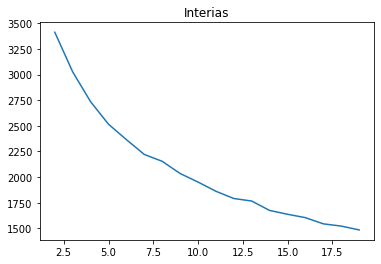

Cat len: 15
[12  4  5 ...  2 11 12]


NameError: name 'get_mapping_dict' is not defined

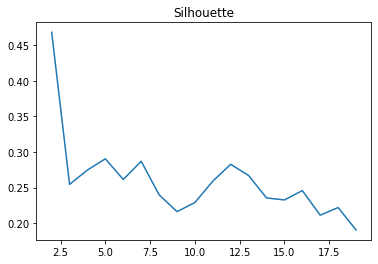

In [9]:
select = SelectKBest(chi2, k=40)
select.fit(x_not_nan, y_not_nan)
x = select.transform(videos)
print(x.shape)

k_list = np.arange(2, 20)
inertias = np.zeros_like(k_list, dtype=np.float)
silhouettes = np.zeros_like(k_list, dtype=np.float)
for i, k in enumerate(k_list):
    model = KMeans(k)
    # model.fit(x)
    labels = model.fit_predict(x)
    inertias[i] = model.inertia_
    silhouettes[i] = silhouette_score(x, labels)

plt.plot(k_list, inertias)
plt.title("Interias")
plt.show()
plt.plot(k_list, silhouettes)
plt.title("Silhouette")
print(f"Cat len: {len(categories)}")
model = KMeans(len(categories))
model.fit(x)
y = model.predict(x)
print(y)
show_stats(y_hat, y_hat_nans, y)


Semi supervised Constrained KMeans (punkt 3.1 z https://arxiv.org/pdf/1806.01547v2.pdf)

In [97]:
print(np.unique(y_not_nan))
print(categories)
print(num_groups, len(categories))
print(x_not_nan.shape[0]+ x_only_nan.shape[0], videos.shape[0])

[ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29. 43.]
['Entertainment', 'People & Blogs', 'Sports', 'Music', 'Howto & Style', 'Gaming', 'Film & Animation', 'News & Politics', 'Comedy', 'Travel & Events', 'Education', 'Pets & Animals', 'Science & Technology', 'Autos & Vehicles', 'Nonprofits & Activism']
16 15
8735 8735


In [96]:
groups_index = np.unique(y_not_nan)
groups_dict = {e:i for i,e in enumerate(groups_index)}
num_groups = len(groups_index)

# print(groups_dict)

groups = [[] for x in range(num_groups)]
for xp,yp in zip(x_not_nan,y_not_nan):
    groups[groups_dict[yp]].append(xp)

centroids = []
for g in groups:
    centroids.append(np.mean(g, axis = 0))

centroids = np.array(centroids)
print(centroids.shape)


(16, 77)


In [93]:
new_centroids = centroids[:]

for itr in range(100):
    model = KMeans(n_clusters = num_groups, init = new_centroids, n_init = 1,  max_iter = 1)
    labels = model.fit_predict(x_only_nan)
    new_groups = [[] for x in range(num_groups)]
    for i,l in enumerate(labels):
        new_groups[l].append(x_only_nan[i])


    new_centroids = []
    for i,g in enumerate(new_groups):
        g = g + groups[i]
        new_centroids.append(np.mean(g, axis = 0))
    new_centroids = np.array(new_centroids)

y = model.predict(videos)
show_stats(y_hat, y_hat_nans, y)




{0: 10.0, 1: 19.0, 2: 10.0, 3: 15.0, 4: 17.0, 5: 25.0, 6: 24.0, 7: 24.0, 8: 24.0, 9: 24.0, 10: 25.0, 11: 24.0, 12: 27.0, 13: 28.0, 14: 10.0, 15: 10.0}
Accuracy: 0.3941614195764167
F1: 0.25191083276275494
Precision: 0.3386610341568044
Recall: 0.2440992529971345
ROC AUC Score OVR: 0.5961524615394606
ROC AUC Score OVO: 0.5961524615394606
/home/michal/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AHC - bo mamy zdefiniowaną liczbę grup?

In [ ]:
model = AgglomerativeClustering(len(categories), compute_full_tree=True)
# model = DBSCAN(eps=0.6, min_samples=5)
model.fit(x)
y = model.labels_

show_stats(y_hat, y_hat_nans, y)

DBSCAN - bo mamy grupy różnej wielkości ?

In [ ]:
model = DBSCAN(eps=0.1, min_samples=5)
model.fit(x)
y = model.labels_
show_stats(y_hat, y_hat_nans, y)

### DBSCAN eps Tuning

In [ ]:
nn = NearestNeighbors(n_neighbors=11)
neighbors = nn.fit(x)
dist, ind = neighbors.kneighbors()

dist = np.sort(dist[:, 10], axis=0)

plt.plot(dist)
plt.xlabel("Points")
plt.ylabel("Dist")
plt.show()